In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.signal
from scipy.fftpack.realtransforms import dct,idct
from siac.utils import diffFilter,filt,dctND

Consider an inverse correlation function $\mathcal{C}^{-1}$ of the form:

$$
\mathcal{C}^{-1} =  \frac{1}{\sigma_s^2} \left( I + s D^TD \right) = \frac{1}{\sigma_s^2} I +  \frac{1}{\sigma_s^2} s D^TD 
$$
    
where $s$ controls the correlation length and $\frac{1}{\sigma_s^2}$, a function of $s$, normalises the scale.

We can express $D^TD$  as $U^T \Lambda^2 U$ where $U$ is the eigenvector matrix of $D^TD$ and $\Lambda^2$ a diagonal matrix with entries $\lambda_i^2$ for row,column $i$. Then:

$$
\mathcal{C}^{-1} = \frac{1}{\sigma_s^2} \left( I + s U^T \Lambda^2 U \right) 
$$

and:

$$
\mathcal{C} = \sigma_s^2 U^T\Gamma^2 U 
$$

with $\Gamma^2$ a diagonal matrix with entries $\gamma_i^2$. Then:

$$
\gamma_i^2 =  \left( 1  + s \lambda_i^2 \right)^{-1}
$$

The normalisation factor $\frac{1}{\sigma_s^2}$ is the trace of $\Gamma^2$ divided by $n_x$, which we can write as:

$$
\frac{1}{\sigma_s^2} = \frac{1}{n_x \times n_y}\sum^{j=n_j }_{j=1}  \sum^{i=n_x }_{i=1} \gamma_{i,j}^2 = \overline{\gamma^{2}}
$$

So, asymptotically (for large $n_x$):


$$
\mathcal{C} = \sigma_s^2 U^T\Gamma^2 U 
$$

with $\sigma_s^2 = 1/\overline{\gamma^{2}}$. 

In [189]:
gammas = np.array([ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, \
                   1, 2, 3, 4, 5, 6, 7, 8, 9, \
                   1e1,50])
gamma_small = np.array([ 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5])
gammas = np.concatenate([gamma_small,np.arange(1,50)])
ss = gammas**2
print(ss.min(),ss.max())
print(ss)

1.0000000000000002e-10 2401.0
[1.000e-10 1.000e-08 1.000e-06 1.000e-04 1.000e-02 2.500e-01 1.000e+00
 4.000e+00 9.000e+00 1.600e+01 2.500e+01 3.600e+01 4.900e+01 6.400e+01
 8.100e+01 1.000e+02 1.210e+02 1.440e+02 1.690e+02 1.960e+02 2.250e+02
 2.560e+02 2.890e+02 3.240e+02 3.610e+02 4.000e+02 4.410e+02 4.840e+02
 5.290e+02 5.760e+02 6.250e+02 6.760e+02 7.290e+02 7.840e+02 8.410e+02
 9.000e+02 9.610e+02 1.024e+03 1.089e+03 1.156e+03 1.225e+03 1.296e+03
 1.369e+03 1.444e+03 1.521e+03 1.600e+03 1.681e+03 1.764e+03 1.849e+03
 1.936e+03 2.025e+03 2.116e+03 2.209e+03 2.304e+03 2.401e+03]


In [190]:
def getF(s,nx=None):
    # make nx quite big to avoid edge effects
    if nx is None:
        nx = int(500*s/10)
        nx = np.min([5000,np.max([1000,nx])])
    
    shape = (nx,nx)
    halfx = int(nx/2)
    lambda_i = diffFilter(shape,axis=(0,1))
    gamma_i2 = 1/(1 +  s * lambda_i * lambda_i)
    gamma2bar = np.mean(gamma_i2)  
    sigmas = np.sqrt(1./gamma2bar)
    
    # impulse function
    I = np.zeros(shape)
    I[halfx,halfx]=1
    F = filt(I,gamma_i2 * sigmas**2) 
    return F.max(),F,nx,sigmas

ts = np.zeros_like(ss).astype(float)
ns = np.zeros_like(ss).astype(float)
sigmas = np.zeros_like(ss).astype(float)

for i,s in enumerate(ss):
    print(f'{s}',end='..')
    ts[i],a,ns[i],sigmas[i] = getF(s)

1.0000000000000002e-10..1e-08..1e-06..0.0001..0.010000000000000002..0.25..1.0..4.0..9.0..16.0..25.0..36.0..49.0..64.0..81.0..100.0..121.0..144.0..169.0..196.0..225.0..256.0..289.0..324.0..361.0..400.0..441.0..484.0..529.0..576.0..625.0..676.0..729.0..784.0..841.0..900.0..961.0..1024.0..1089.0..1156.0..1225.0..1296.0..1369.0..1444.0..1521.0..1600.0..1681.0..1764.0..1849.0..1936.0..2025.0..2116.0..2209.0..2304.0..2401.0..

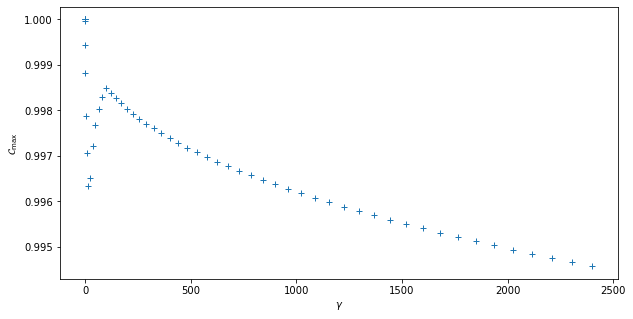

In [191]:
# check the normalisation works
# if it does, then ts which is
# C_max should be 1.0
plt.figure(figsize=(10,5))
plt.plot(ss,ts,'+')
plt.xlabel('$\gamma$')
_=plt.ylabel('$\mathcal{C}_{\max}$')

In [192]:
# save the results
d = {'s':ss, 'gamma':gammas,'sigmas':sigmas,\
     'scale test':ts,'ns':ns }
np.savez('sigmaLUT.npz',**d)

Examine $\sigma_s^2$  = $1/\overline{\gamma^{2}}$ as a function of $s$:

rmse: 0.49
[1.03505048]


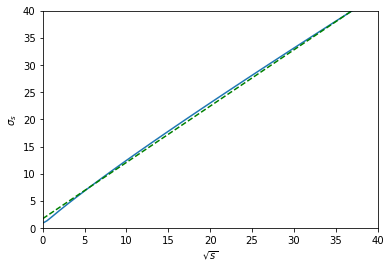

In [193]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

npow = 2
X = np.array([gammas**i for i in range(1,npow)]).T
y = sigmas
model = LinearRegression()
model.fit(X, y)
yhat = model.predict(X)
mse = mean_squared_error(y, yhat)
print(f'rmse: {np.sqrt(mse):.2f}')
print(model.coef_)

plt.plot(gammas,sigmas)

# the main effect
# for low s is 
# sigmas ~= 1 + gammas*k
# with k ~= 1.1
plt.plot(gammas,yhat,'g--')
plt.xlim(0,40)
plt.ylim(0,40)
plt.xlabel('$\sqrt{s}$')
_=plt.ylabel('$\sigma_s$')

One interesting feature  is that for low to moderate $s$ (up to 25 perhaps) we have $\sigma_s \approx 1 + 1.035 \sqrt{s}$ (the green line above).

## Implications

So we have the inverse correlation function:


$$
\mathcal{C}^{-1} =  \sigma_s^{-2} \left( I + s D^TD \right) = \sigma_s^{-2} I +  \sigma_s^{-2} s D^TD 
$$

with $\sigma_s \approx 1 + 1.05 \sqrt{s}$.

which leads to the inverse covariance function:

$$
C^{-1} =  \frac{1}{\sigma_s^2 \sigma_x^2} \left( I + s D^TD \right) = \frac{1}{\sigma_s^2  \sigma_x^2}  I +  \frac{1}{\sigma_s^2  \sigma_x^2}  s D^TD  
$$

and the covariance function:

$$
C = \sigma_s^2 \sigma_x^2 U^T  \Gamma^2 U
$$

so, e.g. we have $\sigma_x = 0.3$ and $s = 1600$ (high)

So the covariance function should be:

40.0 40.0
lut 42.96316535448708
explicit 41.40350871791929
90000
0.08960383982276593 0.08321629434496328 0.09


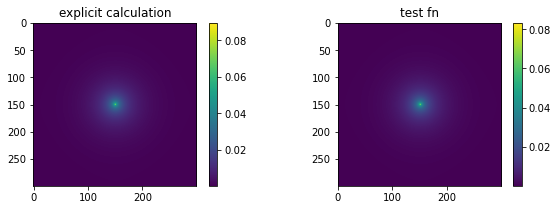

In [194]:
s = 1600
sigma_x = 0.3
# set gammas

# LUT to get sigma_s
gamma = np.sqrt(s)
ilut = np.argmin(np.abs(gammas - gamma))
sigma_s = sigmas[ilut]
gamma2bar = 1./(sigma_s*sigma_s)

print(gammas[ilut],gamma)
print('lut',sigma_s)

nx = 300
shape = (nx,nx)
halfx = int(nx/2)

# eigenvalues
lambda_i = diffFilter(shape,axis=(0,1))
gamma_i2 = 1/(1 +  s * lambda_i * lambda_i)

# this will vary slightly with sx
print('explicit',np.sqrt(1./gamma_i2.mean()))

# impulse function
I = np.zeros(shape)
I[halfx,halfx]=1

# from above 
C = filt(I,gamma_i2) * (sigma_s*sigma_s) * (sigma_x * sigma_x)

fig,(im1,im2) = plt.subplots(1,2,figsize=(10,3))
im = im1.imshow(C)
im1.set_title("explicit calculation")
fig.colorbar(im, ax=im1)

# use getF to see impact of nx
Ca = getF(s,nx=nx)[1]* (sigma_x * sigma_x)
im = im2.imshow(Ca)
im2.set_title("test fn")
fig.colorbar(im, ax=im2)

print(len(np.where(C>0)[0]))
print(C.max(),Ca.max(),sigma_x*sigma_x)

$$
C = \sigma_s^2 \sigma_x^2 U^T  \Gamma^2 U
$$

So, if e.g. we design a prior covariance constraint for DA, we can phrase it as:
$$
C^{-1} =  \frac{1}{\sigma_s^2 \sigma_x^2} \left( I + s D^TD \right) 
$$

or, in the form of Lewis et al. (2012):

$$
C^{-1} =  \frac{1}{\sigma_p^2}  I + \gamma^2 D^TD 
$$

To use this form, we need to set:

$$
\sigma_p^2 = \sigma_s^2 \sigma_x^2
$$

and 

$$
\gamma^2 = \frac{s}{\sigma_s^2 \sigma_x^2} \approx \frac{s}{ \sigma_x^2 (1 + \sqrt{s})^2}
$$

In [195]:
# set the intended terms
s = 1600
sigma_x = 0.3
#######

# LUT to get sigma_s
gamma = np.sqrt(s)
ilut = np.argmin(np.abs(gammas - gamma))
sigma_s = sigmas[ilut]
print(gammas[ilut],gamma)
print('lut',sigma_s)

# use these in Lewis et al formulae
sigma_p2 = (sigma_s*sigma_s) * (sigma_x * sigma_x)
gamma2 = s / sigma_p2
print(f'desired:     {np.sqrt(s):.2f} {sigma_x:.2f}')
print(f'transformed: {np.sqrt(gamma2):.2f} {np.sqrt(sigma_p2):.2f}')
print(f'approx {1/(np.sqrt(2)*sigma_x):.2f}')
print(f'inflation factor on sigma_x {sigma_s:.2f}')

40.0 40.0
lut 42.96316535448708
desired:     40.00 0.30
transformed: 3.10 12.89
approx 2.36
inflation factor on sigma_x 42.96


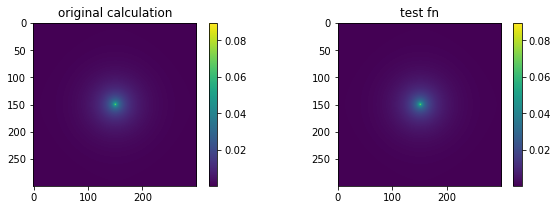

In [196]:
nx = 300
shape = (nx,nx)
halfx = int(nx/2)

# eigenvalues
lambda_i = diffFilter(shape,axis=(0,1))
# full form
gamma_i2 = 1/(1/sigma_p2 +  gamma2 * lambda_i * lambda_i)

# impulse function
I = np.zeros(shape)
I[halfx,halfx]=1

# from above 
C_ = filt(I,gamma_i2) 

fig,(im1,im2) = plt.subplots(1,2,figsize=(10,3))
im = im1.imshow(C)
im1.set_title("original calculation")
fig.colorbar(im, ax=im1)

# use formula here
im = im2.imshow(C_)
im2.set_title("test fn")
fig.colorbar(im, ax=im2)

Text(0.5, 0, '$\\sigma_s$')

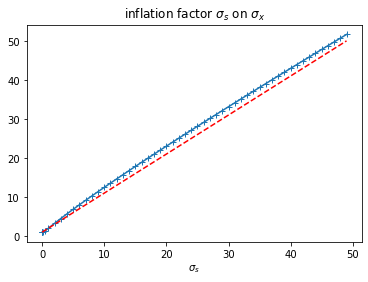

In [197]:
plt.title('inflation factor $\sigma_s$ on $\sigma_x$')
plt.plot(gammas,sigmas,'+-')
plt.plot(gammas,(1+gammas),'r--')
plt.xlabel('$\sqrt{s}$')
plt.xlabel('$\sigma_s$')

## Conclusions

To use Lewis form to describe prior covariance function, for some desired prior variance $\sigma_x^2$ and smoothness factor $s$, you need to scale $\sigma_x$ by a factor $\sigma_s$ given by the LUT here or $\approx (1 + \sqrt{s})$. 

You also need to use:

$$
\gamma^2 = \frac{s}{\sigma_s^2 \sigma_x^2} \approx \frac{s}{ \sigma_x^2 (1 + \sqrt{s})^2}
$$


In [200]:

def scaler(sigma_x,s):
    '''
    warning: dont use beyond extent of training
    ... its only a LUT!
    '''
    d = np.load('sigmaLUT.npz')
    gammas = d['gamma']
    # LUT to get sigma_s
    gamma = np.sqrt(s)
    ilut = np.argmin(np.abs(gammas - gamma))
    sigma_s = sigmas[ilut]
    sigma_p = sigma_s*sigma_x
    return sigma_p,s/(sigma_p**2)

In [201]:
print(scaler(0.3,10))

(1.346317232599291, 5.517028031517673)


In [202]:
print(scaler(0.3,5))

(0.9763425664447036, 5.245242316571189)


In [203]:
print(scaler(0.3,2))

(0.5948492994308471, 5.652181337756496)
